In [1]:
from __future__ import division
from __future__ import print_function

import os
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import display, Math
from scipy.misc import imread

In [50]:
def plot_loss(errs, title='Loss', ylabel='Loss', step=1):
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.plot(range(0, len(errs) * step, step), errs)
    plt.show()

def mean_norm(dataset):
    """
    subtract mean and do normalization for each image
    Args:
        dataset: dataset with shape [N, H, W, C]
                 N data points, Height H, Width W, Channel C
    Return:
        dataset: processed dataset
    """
    N, H, W, C = dataset.shape
    X = dataset.reshape((N, -1))
    X -= np.mean(X, axis = 0)
    X /= np.std(X, axis = 0)
    X = X.reshape((N, H, W, C))
    return X

In [3]:
# Read label names
with open('tiny-imagenet-200/wnids.txt') as f:
    wnids = [str.strip(s) for s in f]

In [4]:
# Construct labels
labs = [i for l in [[j] * 500 for j in range(200)] for i in l]
labs = np.eye(200)[labs]

In [5]:
# Read images
imgs = []
for wnid in wnids:
    subdir = 'tiny-imagenet-200/train/%s/images/' % wnid
    files = [subdir + s for s in os.listdir(subdir)]
    imgs.extend([imread(f, mode='RGB') for f in files])

In [6]:
# Shuffle images and labels
comb = zip(labs, imgs)
random.shuffle(comb)
s_labs, s_imgs = zip(*comb)

In [7]:
# Prepare data
train_imgs = mean_norm(np.array(s_imgs, dtype=np.float32))
train_labs = np.array(s_labs, dtype=np.int32)

In [61]:
learning_rate = 0.0001

# Network shape

def weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))
def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

activate = tf.nn.relu
def conv(x, filter_size, filters_out, stride=1):
    filters_in = x.get_shape()[-1].value
    w = weight([filter_size, filter_size, filters_in, filters_out])
    b = bias([filters_out])
    return activate(
        tf.nn.conv2d(x, w, [1, stride, stride, 1], 'SAME') + b)
def fc(x, nodes):
    vec_in = x.get_shape()[-1].value
    w = weight([vec_in, nodes])
    b = bias([nodes])
    return tf.matmul(x, w) + b

# Creates entire network. Takes a function which makes
# the convolutional layers.
def mk_net(mk_conv):
    # Endpoints
    _x = tf.placeholder(tf.float32, [None, 64, 64, 3])
    _y = tf.placeholder(tf.float32, [None, 200])

    _conv = mk_conv(_x)

    # Flatten, then fully-connected 500 node
    _, w, h, c = [d.value for d in _conv.get_shape()]
    _flat = tf.reshape(_conv, [-1, w * h * c])
    _hidd = activate(fc(_flat, 500))
    _out = fc(_hidd, 200)

    # Optimization
    _cel = tf.nn.softmax_cross_entropy_with_logits(logits=_out, labels=_y)
    _loss = tf.reduce_mean(_cel)
    _opt = tf.train.AdamOptimizer(learning_rate).minimize(_loss)

    # Validation
    _pred = tf.argmax(_out, 1)
    _ans = tf.argmax(_y, 1)
    _err = tf.reduce_mean(tf.cast(tf.not_equal(_pred, _ans), tf.float32))

    _init = tf.global_variables_initializer()
    
    # Return the nodes we need
    return {
        'x': _x,
        'y': _y,
        'opt': _opt,
        'loss': _loss,
        'pred': _pred,
        'err': _err,
        'init': _init,
    }

def plain(x):  
    # Create convolutional layers
    # 16 layers, 3x3 convolutions
    # Pooling via stride + channel increase every 8 layers
    _cur = x
    filters_out = 8
    for _ in range(2):
        _cur = conv(_cur, 3, filters_out, 2)
        for _ in range(7):
            _cur = conv(_cur, 3, filters_out, 1)
        filters_out *= 2
    return _cur

def resnet(x, decay_factor=1):
    # Same as plain, but add residual every 2 layers
    # Optional decaying factor
    _cur = x
    filters_out = 8
    
    for _ in range(2):
        _cur = conv(_cur, 3, filters_out, 2)
        _res = _cur = conv(_cur, 3, filters_out, 1)
        for _ in range(3):
            _cur = conv(_cur, 3, filters_out, 1)
            _res = _cur = conv(_cur, 3, filters_out, 1) + _res * decay_factor
        filters_out *= 2
    return _cur

# def ext_resnet(x):
#     # Our original design.
#     # Add residual every multiple of 2 layers
#     _cur = x
#     filters_out = 8
    
#     def add_residuals(cur, preds):
#         for i, pred in enumerate(reversed(preds)):
#             cur += pred / i
#         return cur
            
#     for _ in range(2):
#         _cur = conv(_cur, 3, filters_out, 2)
#         _cur = conv(_cur, 3, filters_out, 1)
#         preds = [_cur]
#         for _ in range(3):
#             _cur = conv(_cur, 3, filters_out, 1)
#             _cur = conv(_cur, 3, filters_out, 1)
#             _cur = add_residuals(_cur, preds)
#             preds.append(_cur)
#         filters_out *= 2
#     return _cur

In [55]:
# Training
def train(net, imgs, labs, epochs):
    loss = []
    
    with tf.Session() as sess:
        sess.run(net['init'])
        for epoch in range(epochs):
            print(epoch, end='.')

            tot_loss = 0
            for idx in range(0, len(imgs), n_batch):
                feed = {
                    net['x']: imgs[idx:idx + n_batch],
                    net['y']: labs[idx:idx + n_batch],
                }
                _, cur_loss = sess.run([net['opt'], net['loss']], feed)
                tot_loss += cur_loss
            loss.append(tot_loss / n_batch)
            
    print('\nDONE')
    return loss

In [56]:
# Hyperparameters
n_epoch = 500
n_batch = 100

In [64]:
# Train plain network
loss = train(mk_net(ext_resnet), train_imgs[:100], train_labs[:100], 100)

0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.
DONE


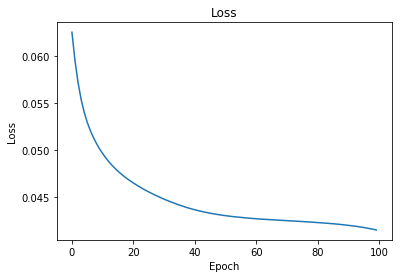

In [52]:
plot_loss(loss)

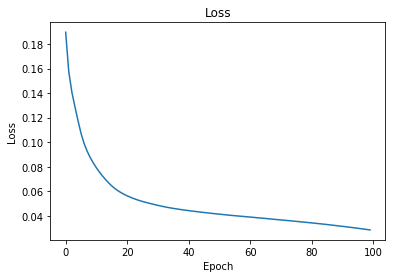

In [58]:
plot_loss(loss)

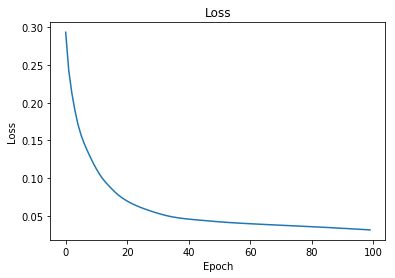

In [66]:
plot_loss(loss)